* 测试迁移学习 baseline
* https://github.com/DavexPro/fashion-tag/blob/master/transfer_learning.ipynb 进行复盘
* 在 baseline 的基础上进行 data_augmentation

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

## 导入数据

* label 文件一共有 79572 行
* 各种维度混合在一起
* 我们的目的是切分开各种维度, 进行训练和模拟
* 那么首先取出个标签的图片进行聚类

In [3]:
df_train = pd.read_csv('data-raw/train_2/Annotations/label.csv')
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
1,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
2,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
3,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn
4,Images/collar_design_labels/fc4a679c2bf209de13...,collar_design_labels,ynnnn


In [4]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

## 加载数据

In [5]:
cur_class = classes[4]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

neck_design_labels: 8154


,image_id,class,label
0,Images/neck_design_labels/166e70259c378ce3814b...,neck_design_labels,nnnny
1,Images/neck_design_labels/22ddc13d269821bec736...,neck_design_labels,nnnny
2,Images/neck_design_labels/d84d1e27a2178a35bd03...,neck_design_labels,ynnnn
3,Images/neck_design_labels/09cd19e9b432a562f765...,neck_design_labels,ynnnn
4,Images/neck_design_labels/5f5df0872d733a646c51...,neck_design_labels,nynnn


In [6]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
prefix_cls = cur_class.split('_')[0]

In [42]:
crip_high=int(width*0.5)
crip_width_start=int(width*0.25)
crip_width_end=int(width*0.75)
for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    if len(tmp_label) > n_class:
        print(df_load['image_id'][i])
    X[i] = cv2.resize(cv2.imread('data-raw/train_2/{0}'.format(df_load['image_id'][i])), (width, width))
    X[i] = cv2.resize(X[i][:crip_high], (width, width))
    X[i] = cv2.resize(X[i][:][:,crip_width_start:crip_width_end], (width, width))
    y[i][tmp_label.find('y')] = 1

100%|██████████| 8154/8154 [00:38<00:00, 209.17it/s]


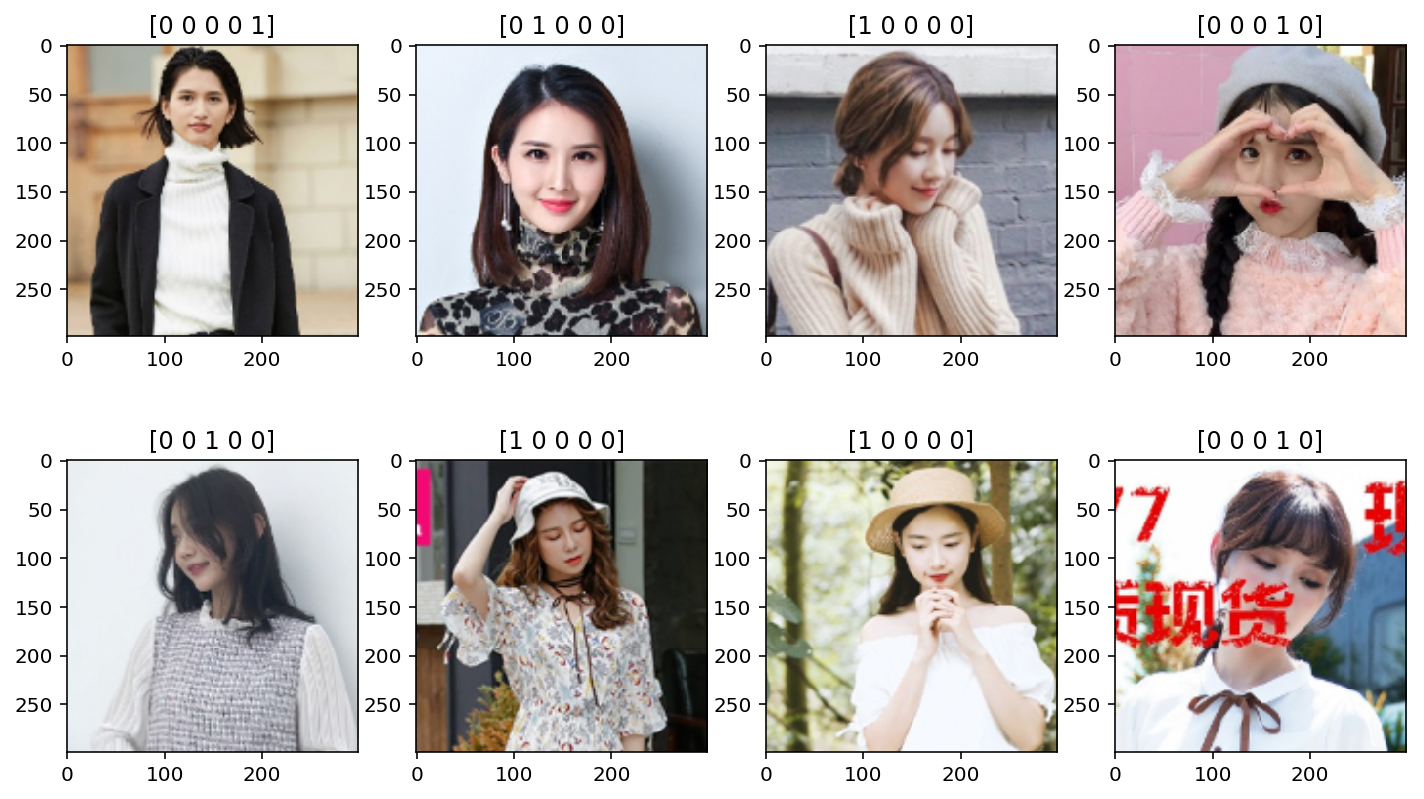

In [44]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(y[random_index])

## 提取特征

In [45]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_resnet_v2 import preprocess_input
#from keras.applications.densenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
import keras

Using TensorFlow backend.


In [46]:
cnn_model =InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')

In [47]:
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

## 划分训练/测试集

In [49]:
x_train_path='data-raw/train_2/{}X_train_299_clip_w_h.bc'.format(prefix_cls)
x_valid_path='data-raw/train_2/{}X_valid_299_clip_w_h.bc'.format(prefix_cls)
y_train_path='data-raw/train_2/{}y_train_299_clip_w_h.bc'.format(prefix_cls)
y_valid_path='data-raw/train_2/{}y_vaild_299_clip_w_h.bc'.format(prefix_cls)

In [16]:
X_train=load_array(x_train_path)
X_valid=load_array(x_valid_path)
y_train=load_array(y_train_path)
y_valid=load_array(y_valid_path)

In [51]:
# Compile the model
adam = Adam(lr=1e-3)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Set a learning rate annealer
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            #patience=3,
                                            #verbose=1,
                                            #factor=0.1,
                                            #min_lr=0.0000001)

In [52]:
epochs = 32
batch_size = 32

In [ ]:
# %%time
# prefix_cls = cur_class.split('_')[0]

# checkpointer = ModelCheckpoint(filepath='models/{0}_weights.h5'.format(prefix_cls), verbose=1, 
#                                save_best_only=True, save_weights_only=True,mode='val_acc')

# #model.load_weights('models/{0}_weights.h5'.format(prefix_cls))

# try:
#     # Fit the model
#     h = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
#               callbacks=[EarlyStopping(patience=3), checkpointer], 
#               shuffle=True, 
#                validation_data=(X_valid, y_valid))
# except KeyboardInterrupt:
#     print('KeyboardInterrupt')

Train on 5012 samples, validate on 684 samples
Epoch 1/10


## 数据增强

In [53]:
datagen = ImageDataGenerator(
        featurewise_center =False ,# set input mean to 0 over the dataset
        samplewise_center = False ,# set each sample mean to 0
        featurewise_std_normalization = False, # divide inputs by std of the dataset
        samplewise_std_normalization = False, # divide each input by its std
        zca_whitening = False, # apply ZCA whitening
        rotation_range = 20, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # randomly zoom image
        width_shift_range = 0, # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0, # randomly shift images vertivally (fraction of total heigth)
        horizontal_flip = True, # randomly flip images
        vertical_flip = False,
        shear_range = 0,
        #brightness_range=10,
        fill_mode = 'constant',
        cval = 0)


#datagen.fit(X_train,seed=123)

In [54]:
%%time
#prefix_cls = cur_class.split('_')[0]

checkpointer = ModelCheckpoint(filepath='models/{0}_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, save_weights_only=True,mode='val_acc')

#model.load_weights('models/{0}_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls))

try:
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data=(X_valid, y_valid),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks=[EarlyStopping(patience=20), checkpointer])
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Epoch 1/32
229/229 [==============================] - 240s 1s/step - loss: 1.0974 - acc: 0.5768 - val_loss: 1.2942 - val_acc: 0.5870

Epoch 00001: val_loss improved from inf to 1.29417, saving model to models/neck_clip_w_h_resnet_all_mem_weights.h5
Epoch 2/32
229/229 [==============================] - 175s 763ms/step - loss: 0.8674 - acc: 0.6742 - val_loss: 0.9795 - val_acc: 0.6262

Epoch 00002: val_loss improved from 1.29417 to 0.97948, saving model to models/neck_clip_w_h_resnet_all_mem_weights.h5
Epoch 3/32
229/229 [==============================] - 175s 763ms/step - loss: 0.7607 - acc: 0.7109 - val_loss: 1.0874 - val_acc: 0.6324

Epoch 00003: val_loss did not improve from 0.97948
Epoch 4/32
229/229 [==============================] - 175s 763ms/step - loss: 0.6857 - acc: 0.7505 - val_loss: 0.8548 - val_acc: 0.6850

Epoch 00004: val_loss improved from 0.97948 to 0.85478, saving model to models/neck_clip_w_h_resnet_all_mem_weights.h5
Epoch 5/32
229/229 [==============================]

In [55]:
# Compile the model
adam = Adam(lr=1e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
%%time
#prefix_cls = cur_class.split('_')[0]

checkpointer = ModelCheckpoint(filepath='models/{0}2_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, save_weights_only=True,mode='val_acc')

model.load_weights('models/{0}_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls))

try:
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data=(X_valid, y_valid),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks=[EarlyStopping(patience=20), checkpointer])
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Epoch 1/32
229/229 [==============================] - 233s 1s/step - loss: 0.4125 - acc: 0.8533 - val_loss: 0.4694 - val_acc: 0.8272

Epoch 00001: val_loss improved from inf to 0.46941, saving model to models/neck2_clip_w_h_resnet_all_mem_weights.h5
Epoch 2/32
229/229 [==============================] - 174s 758ms/step - loss: 0.3220 - acc: 0.8867 - val_loss: 0.4899 - val_acc: 0.8272

Epoch 00002: val_loss did not improve from 0.46941
Epoch 3/32
229/229 [==============================] - 173s 757ms/step - loss: 0.2863 - acc: 0.8965 - val_loss: 0.4936 - val_acc: 0.8309

Epoch 00003: val_loss did not improve from 0.46941
Epoch 4/32
229/229 [==============================] - 174s 758ms/step - loss: 0.2418 - acc: 0.9166 - val_loss: 0.5258 - val_acc: 0.8370

Epoch 00004: val_loss did not improve from 0.46941
Epoch 5/32
 87/229 [==========>...................] - ETA: 1:43 - loss: 0.1878 - acc: 0.9407KeyboardInterrupt
CPU times: user 27min, sys: 2min 15s, total: 29min 16s
Wall time: 14min 11s


In [65]:
# Compile the model
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
%%time
#prefix_cls = cur_class.split('_')[0]

checkpointer = ModelCheckpoint(filepath='models/{0}3_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, save_weights_only=True,mode='val_acc')

model.load_weights('models/{0}2_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls))

try:
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data=(X_valid, y_valid),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks=[EarlyStopping(patience=20), checkpointer])
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Epoch 1/32
229/229 [==============================] - 246s 1s/step - loss: 0.3236 - acc: 0.8901 - val_loss: 0.4637 - val_acc: 0.8395

Epoch 00001: val_loss improved from inf to 0.46375, saving model to models/neck3_clip_w_h_resnet_all_mem_weights.h5
Epoch 2/32
229/229 [==============================] - 176s 768ms/step - loss: 0.3160 - acc: 0.8873 - val_loss: 0.4574 - val_acc: 0.8395

Epoch 00002: val_loss improved from 0.46375 to 0.45742, saving model to models/neck3_clip_w_h_resnet_all_mem_weights.h5
Epoch 3/32
229/229 [==============================] - 175s 766ms/step - loss: 0.3033 - acc: 0.8943 - val_loss: 0.4639 - val_acc: 0.8431

Epoch 00003: val_loss did not improve from 0.45742
Epoch 4/32
229/229 [==============================] - 175s 765ms/step - loss: 0.2891 - acc: 0.8982 - val_loss: 0.4670 - val_acc: 0.8419

Epoch 00004: val_loss did not improve from 0.45742
Epoch 5/32
 44/229 [====>.........................] - ETA: 2:15 - loss: 0.3067 - acc: 0.8849KeyboardInterrupt
CPU tim

In [67]:
# Compile the model
adam = Adam(lr=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
%%time
#prefix_cls = cur_class.split('_')[0]

checkpointer = ModelCheckpoint(filepath='models/{0}4_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, save_weights_only=True,mode='val_acc')

model.load_weights('models/{0}3_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls))

try:
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data=(X_valid, y_valid),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks=[EarlyStopping(patience=20), checkpointer])
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Epoch 1/32
229/229 [==============================] - 248s 1s/step - loss: 0.3065 - acc: 0.8920 - val_loss: 0.4593 - val_acc: 0.8431

Epoch 00001: val_loss improved from inf to 0.45926, saving model to models/neck4_clip_w_h_resnet_all_mem_weights.h5
Epoch 2/32
229/229 [==============================] - 176s 769ms/step - loss: 0.3052 - acc: 0.8937 - val_loss: 0.4602 - val_acc: 0.8456

Epoch 00002: val_loss did not improve from 0.45926
Epoch 3/32
 62/229 [=======>......................] - ETA: 2:02 - loss: 0.3125 - acc: 0.8853KeyboardInterrupt
CPU times: user 15min 10s, sys: 1min 16s, total: 16min 27s
Wall time: 8min 31s


* 第一个参数是 loss, 第二个参数是 acc

## 测试模型

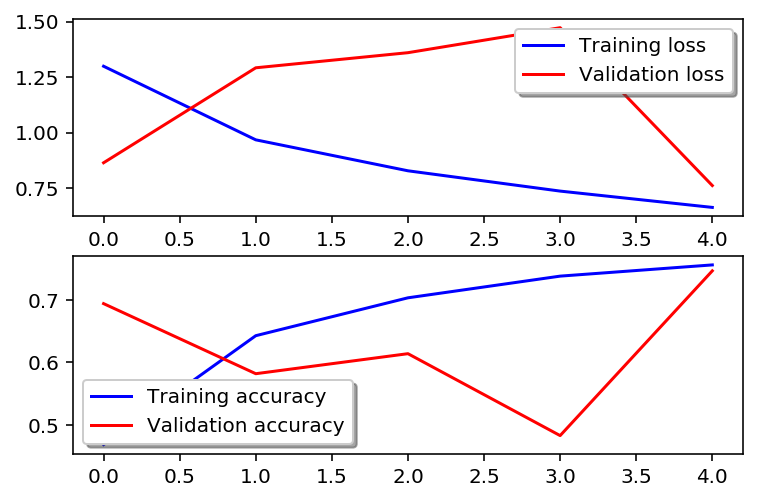

In [20]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 混淆矩阵

In [25]:
## Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This fuction prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plt the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(n_class))

NameError: name 'confusion_matrix' is not defined

## 误差审查

In [ ]:
# Display some error results

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

In [ ]:
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [ ]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((299, 299, 3)))
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
            n += 1

In [ ]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_imaportant_errors = sorted_dela_errors[-12:]

# Show the top 6 errors
display_errors(most_imaportant_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 加载模型

In [57]:
df_test = pd.read_csv('data-raw/week-rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [58]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

neck_design_labels: 1368


,image_id,class
0,Images/neck_design_labels/124df715c45a3f76b6e0...,neck_design_labels
1,Images/neck_design_labels/3eef78e3ecf37deb4f9f...,neck_design_labels
2,Images/neck_design_labels/e80b32f77ab355afe1ca...,neck_design_labels
3,Images/neck_design_labels/e33c717ea13b7ac83305...,neck_design_labels
4,Images/neck_design_labels/9a4313e3f13cbc121e5c...,neck_design_labels


In [61]:
n = len(df_load)

X_test = np.zeros((n, width, width, 3), dtype=np.uint8)
#X_test_hori=X_test[:]
for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('data-raw/week-rank/{0}'.format(df_load['image_id'][i])), (width, width))
    X_test[i] = cv2.resize(X_test[i][:crip_high], (width, width))
    X_test[i] = cv2.resize(X_test[i][:][:,crip_width_start:crip_width_end], (width, width))
    #X_test_hori[i]=cv2.flip(X_test[i], 1)

100%|██████████| 1368/1368 [00:09<00:00, 146.50it/s]


In [28]:
sample,rows,cols,channel = X_test.shape
Gauss_noise = np.random.normal(0, 20, (rows, cols, channel))
X_test_gauss=X_test+Gauss_noise

In [17]:
save_array('data-raw/week-rank/{}X_test.bc'.format(prefix_cls),X_test)
save_array('data-raw/week-rank/{}X_test_hori.bc'.format(prefix_cls),X_test_hori)
save_array('data-raw/week-rank/{}X_test_gauss.bc'.format(prefix_cls),X_test_gauss)

In [22]:
X_test=load_array('data-raw/week-rank/{}X_test.bc'.format(prefix_cls))
X_test_hori=load_array('data-raw/week-rank/{}X_test_hori.bc'.format(prefix_cls))
X_test_gauss=load_array('data-raw/week-rank/{}X_test_gauss.bc'.format(prefix_cls))

In [70]:
model.load_weights('models/{0}4_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls))

In [71]:
test_np_test = model.predict(X_test, batch_size=256)

In [30]:
test_np_test_hori = model.predict(X_test_hori, batch_size=256)

In [31]:
test_np_test_gauss = model.predict(X_test_gauss, batch_size=256)

In [32]:
test_np=(test_np_test+test_np_test_hori+test_np_test_gauss)/3

In [72]:
test_np = model.predict(X_test, batch_size=256)

In [30]:
test_np.shape

(708, 5)

In [73]:
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

,image_id,class,result
0,Images/neck_design_labels/124df715c45a3f76b6e0...,neck_design_labels,0.0021;0.0380;0.0065;0.0278;0.9256
1,Images/neck_design_labels/3eef78e3ecf37deb4f9f...,neck_design_labels,0.0547;0.0069;0.0002;0.0008;0.9375
2,Images/neck_design_labels/e80b32f77ab355afe1ca...,neck_design_labels,0.0002;0.0001;0.9980;0.0017;0.0001
3,Images/neck_design_labels/e33c717ea13b7ac83305...,neck_design_labels,0.0011;0.0340;0.0039;0.0068;0.9541
4,Images/neck_design_labels/9a4313e3f13cbc121e5c...,neck_design_labels,0.0002;0.0002;0.9607;0.0385;0.0004


In [74]:
df_load.to_csv('result/{}_0521_84_resnet_clip_w_h.csv'.format(prefix_cls),header=None, index=False)